## Load Data - Subaru + VW

In [4]:
#DATASET PREPERATION
%matplotlib inline
import torch
import random
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline      
from transforms3d.axangles import axangle2mat  


data = sio.loadmat('../accelane_mat_v3/SBSB_6Khz_preprocessed_AccZ.mat')
start_no = 0
range_len = 50000
train_set = np.zeros((1,range_len))
test_set = np.zeros((1,range_len))
num_datapoints = 20 #10 trials of Lane2, 10 trials of Lane3

#test_datapoints = np.random.randint(0, 10,2)
#test_datapoints = np.append(test_datapoints, np.random.randint(10, 20,2))
#test_datapoints = np.append(test_datapoints, np.random.randint(20, 30,2))
#test_datapoints = np.append(test_datapoints, np.random.randint(30, 40,2))
test_datapoints = [5,  1, 11, 18, 28, 22, 37, 36]
labels = []
for i in range (num_datapoints):     
    if i < 10:
        labels.append(0)
    else:
        labels.append(1)
    varName = "accZ_L{}T{}_p".format(2 if i < 10 else 3, (i%10)+1)
    curr = np.asarray(data[varName][start_no : start_no+range_len]).reshape(1,range_len)
    if i in test_datapoints:
        test_set = np.append(test_set, curr, axis = 0)
    else:
        train_set = np.append(train_set, curr, axis = 0)

data = sio.loadmat('../accelane_mat_v3/VWVW_preprocessed_AccZ.mat')
for i in range (num_datapoints):
    if i < 10:
        labels.append(0)
    else:
        labels.append(1)
    varName = "accZ_L{}T{}_p".format(2 if i < 10 else 3, (i%10)+1)
    curr = np.asarray(data[varName][start_no : start_no+range_len]).reshape(1,range_len)
    if i in test_datapoints:
        test_set = np.append(test_set, curr, axis = 0)
    else:
        train_set = np.append(train_set, curr, axis = 0)

train_set = np.delete(train_set, (0), axis=0) 
test_set = np.delete(test_set, (0), axis=0)

training_size = (num_datapoints*2) - len(test_datapoints)
test_labels = []
train_labels = []

for i in np.arange(len(labels)):
    if i in test_datapoints:
        test_labels.append(labels[i])
    else:
        train_labels.append(labels[i])
                         
train_labels = np.asarray(train_labels).reshape(training_size,1)
test_labels = np.asarray(test_labels).reshape(len(test_datapoints),1)

train_set = np.append(train_set, train_labels, axis = 1)
test_set = np.append(test_set, test_labels, axis = 1)

train_targets_numpy = train_set[:,-1]
train_features_numpy = train_set[:,:-1]
print("Train Features numpy {}".format(train_features_numpy.shape))
print("Train Targets numpy {}".format(train_targets_numpy.shape))

test_targets_numpy = test_set[:,-1]
test_features_numpy = test_set[:,:-1]
print("Test Features numpy {}".format(test_features_numpy.shape))
print("Test Targets numpy {}".format(test_targets_numpy.shape))

num_original_samples = training_size
features_numpy_new = train_features_numpy.T

Train Features numpy (32, 50000)
Train Targets numpy (32,)
Test Features numpy (8, 50000)
Test Targets numpy (8,)


## Training Data Augmentation

### Jittering

In [5]:
def DA_Jitter(X, sigma= 0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

sigma = np.linspace(.1,1,22)
for j in sigma:
    for i in range(num_original_samples):
        train_features_numpy = np.append(train_features_numpy, DA_Jitter(features_numpy_new[:,i], j).reshape(1,-1), axis = 0)
    train_targets_numpy = np.append(train_targets_numpy, train_targets_numpy[:num_original_samples], axis = 0)
print('FeaturesNumpy Output shape after jittering')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after jittering')
print(train_targets_numpy.shape)

FeaturesNumpy Output shape after jittering
(736, 50000)
TargetsNumpy Output shape after jittering
(736,)


### Scaling

In [6]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

sigma = np.linspace(.2,2,22)
for j in sigma:
    for i in range(num_original_samples):
        train_features_numpy = np.append(train_features_numpy, DA_Scaling(features_numpy_new[:,i].reshape(-1,1), j).reshape(1,-1), axis = 0)
    train_targets_numpy = np.append(train_targets_numpy, train_targets_numpy[:num_original_samples], axis = 0)
print('FeaturesNumpy Output shape after scaling')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after scaling')
print(train_features_numpy.shape)

FeaturesNumpy Output shape after scaling
(1440, 50000)
TargetsNumpy Output shape after scaling
(1440, 50000)


### Magnitude Warping

In [7]:
from scipy.interpolate import CubicSpline

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    return np.array([cs_x(x_range)]).transpose()

def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

sigma = np.linspace(.2,2,22)
for j in sigma:
    for i in range(num_original_samples):
        train_features_numpy = np.append(train_features_numpy, DA_MagWarp(features_numpy_new[:,i].reshape(-1,1), j).reshape(1,-1), axis = 0)
    train_targets_numpy = np.append(train_targets_numpy, train_targets_numpy[:num_original_samples], axis = 0)
print('FeaturesNumpy Output shape after magwarping')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after magwarping')
print(train_targets_numpy.shape)

FeaturesNumpy Output shape after magwarping
(2144, 50000)
TargetsNumpy Output shape after magwarping
(2144,)


### Time Warping

In [10]:
#DATA AUGMENTATION
#SINGLE KERNEL 

from scipy.interpolate import CubicSpline

#perform time warping
def GenerateRandomCurvesWithZ(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurvesWithZ(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]    
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

n_sets_time_warping = 1
sigma = np.linspace(.1, 1, 10)
upper_lim = num_original_samples-(num_original_samples%3)
for j in sigma:
    for i in range(0,upper_lim, 3):
        ip = features_numpy_new[:,i:i+3]
        time_warped_ip = DA_TimeWarp(ip, j).T
        train_features_numpy = np.append(train_features_numpy, DA_TimeWarp(ip, j).T , axis = 0)
    train_targets_numpy = np.concatenate((train_targets_numpy,train_targets_numpy[:upper_lim]), axis=None)
print('FeaturesNumpy Output shape after time warping')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after time warping')
print(train_targets_numpy.shape)

FeaturesNumpy Output shape after time warping
(2444, 50000)
TargetsNumpy Output shape after time warping
(2444,)


### Save Full Dataset

In [11]:
np.save("TrainData50K.npy", train_features_numpy)
np.save("TrainLabels50K.npy", train_targets_numpy)
np.save("TestData50K.npy", test_features_numpy)
np.save("TestLabels50K.npy", test_targets_numpy)

## Partition Validation Dataset For Training

In [21]:
from functools import reduce
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
features_train, features_val, targets_train, targets_val = train_test_split(train_features_numpy,
                                                                             train_targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)


featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
targetsTrain = torch.from_numpy(targets_train).type(torch.FloatTensor)
featuresVal = torch.from_numpy(features_val).type(torch.FloatTensor)
targetsVal = torch.from_numpy(targets_val).type(torch.FloatTensor)

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
val = torch.utils.data.TensorDataset(featuresVal,targetsVal)

potential_batch_size_train = sorted(factors(features_train.shape[0]))
potential_batch_size_val = sorted(factors(features_val.shape[0]))

min_batch_train = 32
min_batch_val = 20

batch_size = potential_batch_size_train[np.argmax(np.asarray(potential_batch_size_train) >= min_batch_train )]
batch_size_val = potential_batch_size_val[np.argmax(np.asarray(potential_batch_size_val) >= min_batch_val)]

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size_val, shuffle = True)


print('Shape of Features Train Dataset')
print(featuresTrain.size())
print('Shape of Targets Train Dataset')
print(targetsTrain.size())
print('Shape of Features Validation Dataset')
print(featuresVal.size())
print('Shape of Targets Validation Dataset')
print(targetsVal.size())

print("Batch Size - Train: {} Val: {}".format(batch_size, batch_size_val))

Shape of Features Train Dataset
torch.Size([1955, 50000])
Shape of Targets Train Dataset
torch.Size([1955])
Shape of Features Validation Dataset
torch.Size([489, 50000])
Shape of Targets Validation Dataset
torch.Size([489])
Batch Size - Train: 85 Val: 163


## Model Design

In [87]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv1d(in_channels = 1, out_channels = filters,kernel_size=1000, stride=10),
#             nn.ReLU(),
#             nn.BatchNorm1d(filters))
#         self.layer2 = nn.Sequential(
#             nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=101, stride=10),
#             nn.ReLU(),
#             nn.BatchNorm1d(filters))
#         self.layer3 = nn.Sequential(
#             nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=11, stride=5),
#             nn.ReLU(),
#             nn.BatchNorm1d(filters))
#         self.avgLayer = nn.AvgPool1d(5, stride = 2)
#         self.fc1 = nn.Linear(796,2)

num_filters = 3
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = num_filters,kernel_size=25, stride=10),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters))
        self.avgLayer1 = nn.AvgPool1d(5, stride = 2)
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = num_filters, out_channels = num_filters, kernel_size=10, stride=5),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters))
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = num_filters, out_channels = num_filters, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters))
        self.avgLayer2 = nn.AvgPool1d(10, stride = 2)
        self.drop_out = nn.Dropout(.2)
        self.fc1 = nn.Linear(231,2)


    def forward(self, x):
        out = self.layer1(x)
        out = self.avgLayer1(out)
        out = self.layer2(out)
        out = self.layer3(out) 
        out = self.avgLayer2(out)
        out = self.drop_out(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)
    
    
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        m.bias.data.zero_()
    

model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv1d(1, 3, kernel_size=(25,), stride=(10,))
    (1): ReLU()
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgLayer1): AvgPool1d(kernel_size=(5,), stride=(2,), padding=(0,))
  (layer2): Sequential(
    (0): Conv1d(3, 3, kernel_size=(10,), stride=(5,))
    (1): ReLU()
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv1d(3, 3, kernel_size=(10,), stride=(3,))
    (1): ReLU()
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgLayer2): AvgPool1d(kernel_size=(10,), stride=(2,), padding=(0,))
  (drop_out): Dropout(p=0.2)
  (fc1): Linear(in_features=231, out_features=2, bias=True)
)

## Model Training

/home/mharisha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Current Epoch: 0
Iteration: 1 Loss: 0.4249702990055084 Accuracy: 83 %
Current Epoch: 1
Iteration: 2 Loss: 0.3627966046333313 Accuracy: 85 %
Current Epoch: 2
Iteration: 3 Loss: 0.2933512032032013 Accuracy: 87 %
Current Epoch: 3
Iteration: 4 Loss: 0.163417786359787 Accuracy: 88 %
Current Epoch: 4
Iteration: 5 Loss: 0.23453374207019806 Accuracy: 91 %
Current Epoch: 5
Iteration: 6 Loss: 0.21998484432697296 Accuracy: 92 %
Current Epoch: 6
Iteration: 7 Loss: 0.13851942121982574 Accuracy: 91 %
Current Epoch: 7
Iteration: 8 Loss: 0.12353258579969406 Accuracy: 93 %
Current Epoch: 8
Iteration: 9 Loss: 0.16160503029823303 Accuracy: 92 %
Current Epoch: 9
Iteration: 10 Loss: 0.13971427083015442 Accuracy: 94 %
Current Epoch: 10
Iteration: 11 Loss: 0.09609787911176682 Accuracy: 93 %
Current Epoch: 11
Iteration: 12 Loss: 0.20701374113559723 Accuracy: 93 %
Current Epoch: 12
Iteration: 13 Loss: 0.0994645208120346 Accuracy: 92 %
Current Epoch: 13
Iteration: 14 Loss: 0.22100479900836945 Accuracy: 94 %
Cur

Iteration: 113 Loss: 0.03291424736380577 Accuracy: 96 %
Current Epoch: 113
Iteration: 114 Loss: 0.04650584235787392 Accuracy: 96 %
Current Epoch: 114
Iteration: 115 Loss: 0.04121493548154831 Accuracy: 95 %
Current Epoch: 115
Iteration: 116 Loss: 0.04725975543260574 Accuracy: 96 %
Current Epoch: 116
Iteration: 117 Loss: 0.04576697573065758 Accuracy: 95 %
Current Epoch: 117
Iteration: 118 Loss: 0.04166163131594658 Accuracy: 96 %
Current Epoch: 118
Iteration: 119 Loss: 0.028914064168930054 Accuracy: 96 %
Current Epoch: 119
Iteration: 120 Loss: 0.07484418898820877 Accuracy: 96 %
Current Epoch: 120
Iteration: 121 Loss: 0.06321057677268982 Accuracy: 96 %
Current Epoch: 121
Iteration: 122 Loss: 0.051844675093889236 Accuracy: 96 %
Current Epoch: 122
Iteration: 123 Loss: 0.07409355789422989 Accuracy: 95 %
Current Epoch: 123
Iteration: 124 Loss: 0.08601860702037811 Accuracy: 96 %
Current Epoch: 124
Iteration: 125 Loss: 0.04262308031320572 Accuracy: 96 %
Current Epoch: 125
Iteration: 126 Loss: 0.

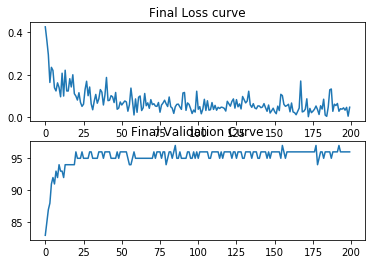

In [88]:
model.apply(weights_init)
num_epochs = 200
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
n_classes = 2

for epoch in range(num_epochs):
    print('Current Epoch: {}'.format(epoch))
    for i, (samples, targets) in enumerate(train_loader):
        train = Variable(samples.view(batch_size,1,-1))
        targets = Variable(targets.type(torch.LongTensor))
        # Clear gradients
        optimizer.zero_grad()
        #setting up model for training
        model.train()
        # Forward propagation
        outputs = model(train)
        outputs = outputs.reshape(batch_size,2)
        # Calculate softmax and cross entropy loss
        loss = criterion(outputs, targets)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
    count += 1
    #accuracy at the end of epoch    
    correct = 0
    total = 0
    # Predict test dataset
    for samples, labels in val_loader:
        test = Variable(samples.view(batch_size_val,1,-1))
        #setting up in test mode
        model.eval()
        # Forward propagation
        outputs = model(test)
        outputs = outputs.view(batch_size_val, n_classes)
        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1].type(torch.FloatTensor)
        # Total number of labels
        total += len(labels)
        # Total correct predictions
        correct += (predicted == labels).sum()
    accuracy = 100 * correct / float(total)
    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)

    print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data.item(), accuracy))

plt.subplot(2,1,1)
plt.title('Final Loss curve')
plt.plot(loss_list)
plt.subplot(2,1,2)
plt.title('Final Validation Curve')
plt.plot(accuracy_list)

## Model Testing

In [89]:
# import matplotlib.pyplot as plt
# import copy
# sample_size = 1
# fig, ax = plt.subplots(2, 8, sharex=True, sharey=True)
# for i in range(test_features_numpy.shape[0]):
#     startNum = np.random.randint(range_len-sample_size)
#     sub_test_features_numpy = copy.deepcopy(test_features_numpy)
#     sub_test_features_numpy[i][:startNum] = [0]
#     sub_test_features_numpy[startNum + sample_size:] = [0]
    
#     ax[0][i].plot(np.arange(sample_size),sub_test_features_numpy[i][startNum:startNum+sample_size])
#     ax[1][i].plot(np.arange(range_len),test_features_numpy[i][:])

test_features = torch.from_numpy(test_features_numpy).type(torch.FloatTensor)
test_targets = torch.from_numpy(test_targets_numpy).type(torch.FloatTensor)
test_totalDataset = torch.utils.data.TensorDataset(test_features,test_targets)
batch_size_test = test_features_numpy.shape[0]
test_loader = torch.utils.data.DataLoader(test_totalDataset, batch_size = batch_size_test, shuffle = True)


print('Testing dataset dimensions')
print('Shape of Features Dataset')
print(test_features.size())
print('Shape of Targets Dataset')
print(test_targets.size())
print("Batch Size: {}".format(batch_size_test))

Testing dataset dimensions
Shape of Features Dataset
torch.Size([8, 50000])
Shape of Targets Dataset
torch.Size([8])
Batch Size: 8


In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

accuracy_list = []
f1_score_list = []
precision_list = []
recall_list = []
y_pred =[]
y_true = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
            samples, labels = data
            samples = Variable(samples.view(batch_size_test,1,-1))
            
            model.eval()
            
            outputs = model(samples)
            outputs = outputs.view(batch_size_test, n_classes)
            
            predictions = torch.argmax(outputs, 1)
            targets = labels
            
            y_pred.extend(predictions)
            y_true.extend(targets)



conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print("Accuracy Score: {}".format(accuracy_score(y_true, y_pred) * 100))
print("F1 Score: {}". format(f1_score(y_true, y_pred) * 100))
print("Precision Score: {}".format(precision_score(y_true, y_pred) * 100))
print("Recall Score: {}".format(recall_score(y_true, y_pred)* 100))

[[4 0]
 [0 4]]
Accuracy Score: 100.0
F1 Score: 100.0
Precision Score: 100.0
Recall Score: 100.0


Text(0.5, 1.0, 'Volkswagen Lane 2')

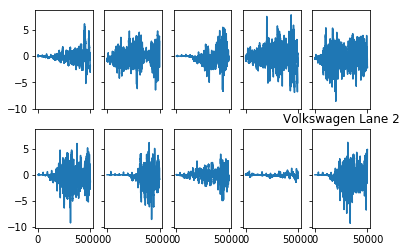

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True)

for i in range(10):
        ax[i%2][i%5].plot(np.arange(50000),vw_features_numpy[i,:])
plt.title("Volkswagen Lane 2")


Text(0.5, 1.0, 'Subaru Lane 2')

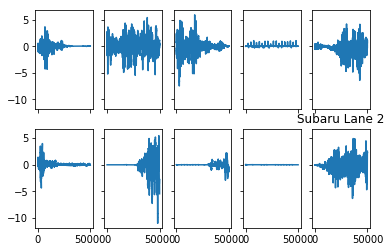

In [42]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True)

for i in range(10):
        ax[i%2][i%5].plot(np.arange(50000),features_numpy[i,:])
plt.title("Subaru Lane 2")